## **RUL Prediction on NASA Tubrofan Jet Engine Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px
import plotly.graph_objects as go
from sklearn import metrics
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

### **Data Modelling for EDA**

In [ ]:
path = '/content/drive/MyDrive/Project/Regression/Dataset/'

# train and test data path
train_path = [path + "train_FD001.txt", path + "train_FD002.txt",
              path + "train_FD003.txt", path + "train_FD004.txt"]

test_path = [path + "test_FD001.txt", path + "test_FD002.txt",
              path + "test_FD003.txt", path + "test_FD004.txt"]

rul_path = [path + "RUL_FD001.txt", path + "RUL_FD002.txt",
              path + "RUL_FD003.txt", path + "RUL_FD004.txt"]

# Attributes to be renamed
column_names = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2',
                   'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7',
                   'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12',
                   'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17',
                   'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']

# Declaration of empty lists to store the processed data
stacked_train_X=[]
stacked_train_y=[]
stacked_test_X=[]
stacked_test_y=[]
data_collector = []

# Iterating through all four data files; train and test
for i in range(4):
  train = pd.read_csv(train_path[i], sep=' ', header = None)                  # train data
  test = pd.read_csv(test_path[i], sep=' ', header = None)                    # test data
  rul = pd.read_csv(rul_path[i], sep=' ', header = None)                      # test rul

  # reset index to prevent slicing errors
  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)
  rul.reset_index(drop=True, inplace=True)

  # drop unnecessary NAN columns
  train = train.drop([26,27], axis='columns')
  # rename columns from default names to relevant attributes
  train.columns = column_names

  # estimating rul for training data
  '''
  the code calculates the remaining cycles for each engine unit by determining how many
  more cycles can be completed before reaching the point of engine failure. It calculates
  the difference between the maximum cycle number recorded for that engine (representing
  its complete life cycle) and the current cycle numbers recorded for that engine.
  '''
  rul_store = []
  for id in train['ID'].unique():
    complete_cycles = train[train['ID']==id]['Cycle'].max()
    remaining = complete_cycles-train[train['ID']==id]['Cycle'].to_list()
    rul_store = rul_store+list(remaining)

  train['RUL'] = rul_store


  # drop unnecessary NAN columns
  test = test.drop([26,27], axis='columns')
  # rename columns from default names to relevant attributes
  test.columns = column_names

  rul.drop([1], axis='columns', inplace=True)
  rul.columns = ['RUL']

  new_test = pd.DataFrame(columns=column_names)
  for i in range(len(rul)):
    new_test = new_test.append(test[test['ID']==(i+1)].tail(1))

  temp_train_data = train.copy()
  # train.drop(['ID'], axis=1, inplace=True)

  train = train[train['RUL']<150]
  train.drop('Cycle', axis=1, inplace=True)
  train.reset_index(drop=True, inplace=True)


  # Separate train features and target(RUL)
  X_train = train.drop('RUL', axis=1)
  y_train = train['RUL']

  # Separate train features and target(RUL)
  X_test = new_test.drop(['ID', 'Cycle'], axis=1)
  y_test = rul

  print(X_train.shape, y_train.shape)
  print(X_test.shape, y_test.shape)


  # Store the splitted data of each train and test file to combine all the data for mass training and validation
  stacked_train_X.append(X_train)
  stacked_train_y.append(y_train)
  stacked_test_X.append(X_test)
  stacked_test_y.append(y_test)

  # collecting all the data as (train_data, test_data, X_train, y_train, X_test, y_test)
  data_collector.append((temp_train_data, test, X_train, y_train, X_test, y_test))

(14931, 25) (14931,)
(100, 24) (100, 1)
(38856, 25) (38856,)
(259, 24) (259, 1)
(14992, 25) (14992,)
(100, 24) (100, 1)
(37261, 25) (37261,)
(248, 24) (248, 1)


In [ ]:
# Concat all subsets of data(FD001+FD002_FD003+FD004) to form a single bigger meta data - train data
processed_train_data = pd.concat(stacked_train_X, axis=0, ignore_index=True)
# Concat all subsets of data(FD001+FD002_FD003+FD004) to form a single bigger meta data - train target
processed_train_targets = pd.concat(stacked_train_y, axis=0, ignore_index=True)

# Concat all subsets of data(FD001+FD002_FD003+FD004) to form a single bigger meta data - test data
processed_test_data = pd.concat(stacked_test_X, axis=0, ignore_index=True)
# Concat all subsets of data(FD001+FD002_FD003+FD004) to form a single bigger meta data - train target
processed_test_targets = pd.concat(stacked_test_y, axis=0, ignore_index=True)

print("TRAINING-->")
print(f"Shape of processed_train_data: {processed_train_data.shape}")
print(f"Shape of processed_train_targets: {processed_train_targets.shape}")

print()
print("TESTING-->")
print(f"Shape of processed_test_data: {processed_test_data.shape}")
print(f"Shape of processed_test_targets: {processed_test_targets.shape}")

TRAINING-->
Shape of processed_train_data: (106040, 25)
Shape of processed_train_targets: (106040,)

TESTING-->
Shape of processed_test_data: (707, 24)
Shape of processed_test_targets: (707, 1)


### **Exploratory Data Analysis**


#### User defined function for plotting

In [ ]:
# user defined function
def plot_predActual(y_test, y_test_hat, data_mode):
    plt.figure(figsize=(12, 6))  # Adjusted figure size

    plt.plot(y_test, label='True RUL', color='darkblue', linewidth=2)
    plt.plot(y_test_hat, label='Predicted RUL', color='red', linestyle='dashed', linewidth=2, alpha=0.8)

    plt.legend(prop={'size': 12})
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('RUL', fontsize=12)
    plt.title(f'True vs. Predicted RUL ({data_mode})', fontsize=14)
    plt.grid(True, alpha=0.5)  # Added grid lines with reduced opacity
    plt.tick_params(labelsize=10)
    plt.tight_layout()  # Improved spacing
    plt.show()

#### Distribution Plot

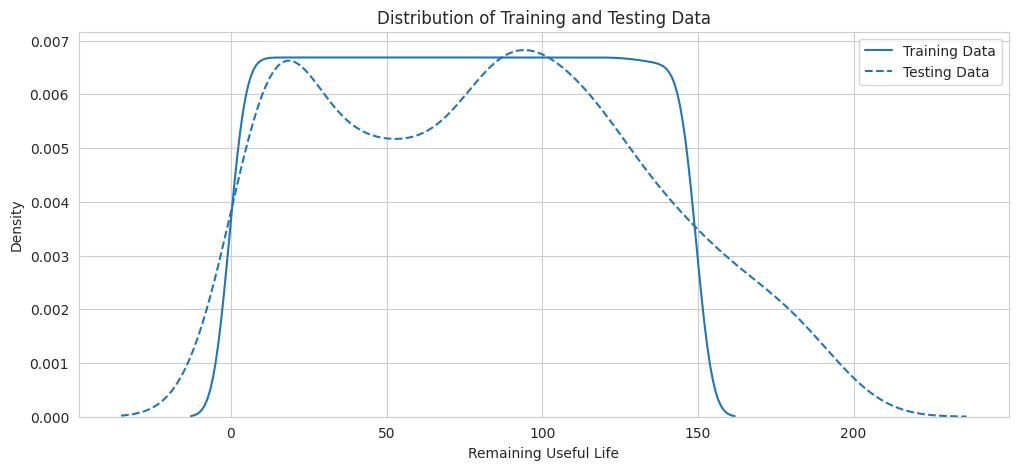

In [ ]:
# Set the plot style to use
sns.set_style("whitegrid")

# Create a new figure
plt.figure(figsize=(12, 5))

# Plot the KDE plot for the training data with a solid line
sns.kdeplot(processed_train_targets, label='Training Data', linestyle='solid')

# Plot the KDE plot for the testing data with a dashed line
sns.kdeplot(processed_test_targets, label='Testing Data', linestyle='dashed')

# Add labels and a title
plt.xlabel('Remaining Useful Life')
plt.ylabel('Density')
plt.title('Distribution of Training and Testing Data')

# Add a legend
plt.legend()

# Show the plot
plt.show()

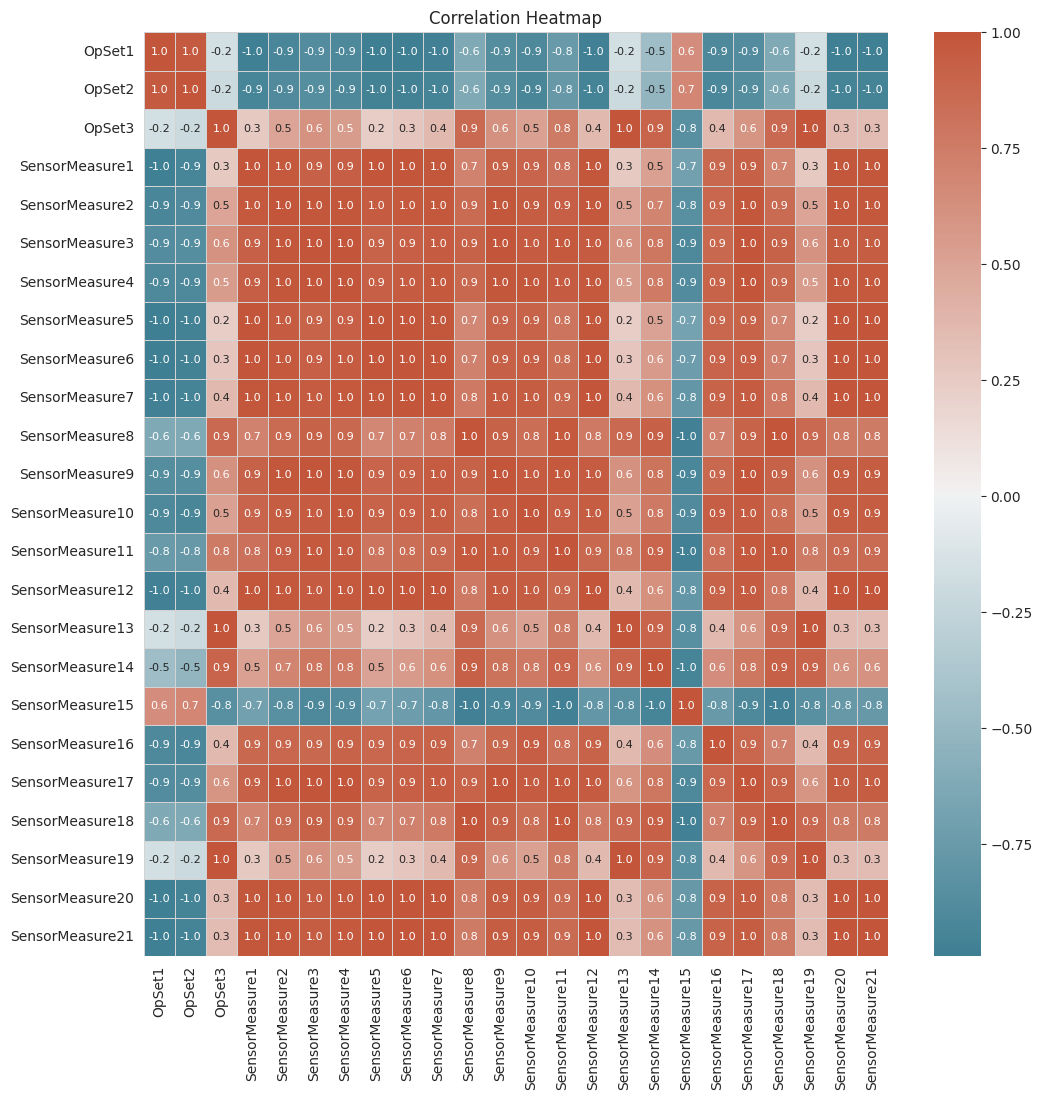

In [ ]:
# Calculate the correlation matrix
correlation = processed_train_data.drop('ID', axis=1).corr()

# Create a new figure
plt.figure(figsize=(12, 12))

# Create a custom color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create a heatmap with annotations and custom color palette
sns.heatmap(correlation,
            cmap=cmap,
            annot=True,
            fmt=".1f",  # Format values with 1 decimal place
            annot_kws={"size": 8},  # Adjust annotation font size
            linecolor='lightgrey',
            linewidth=0.5,)

# Add title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()


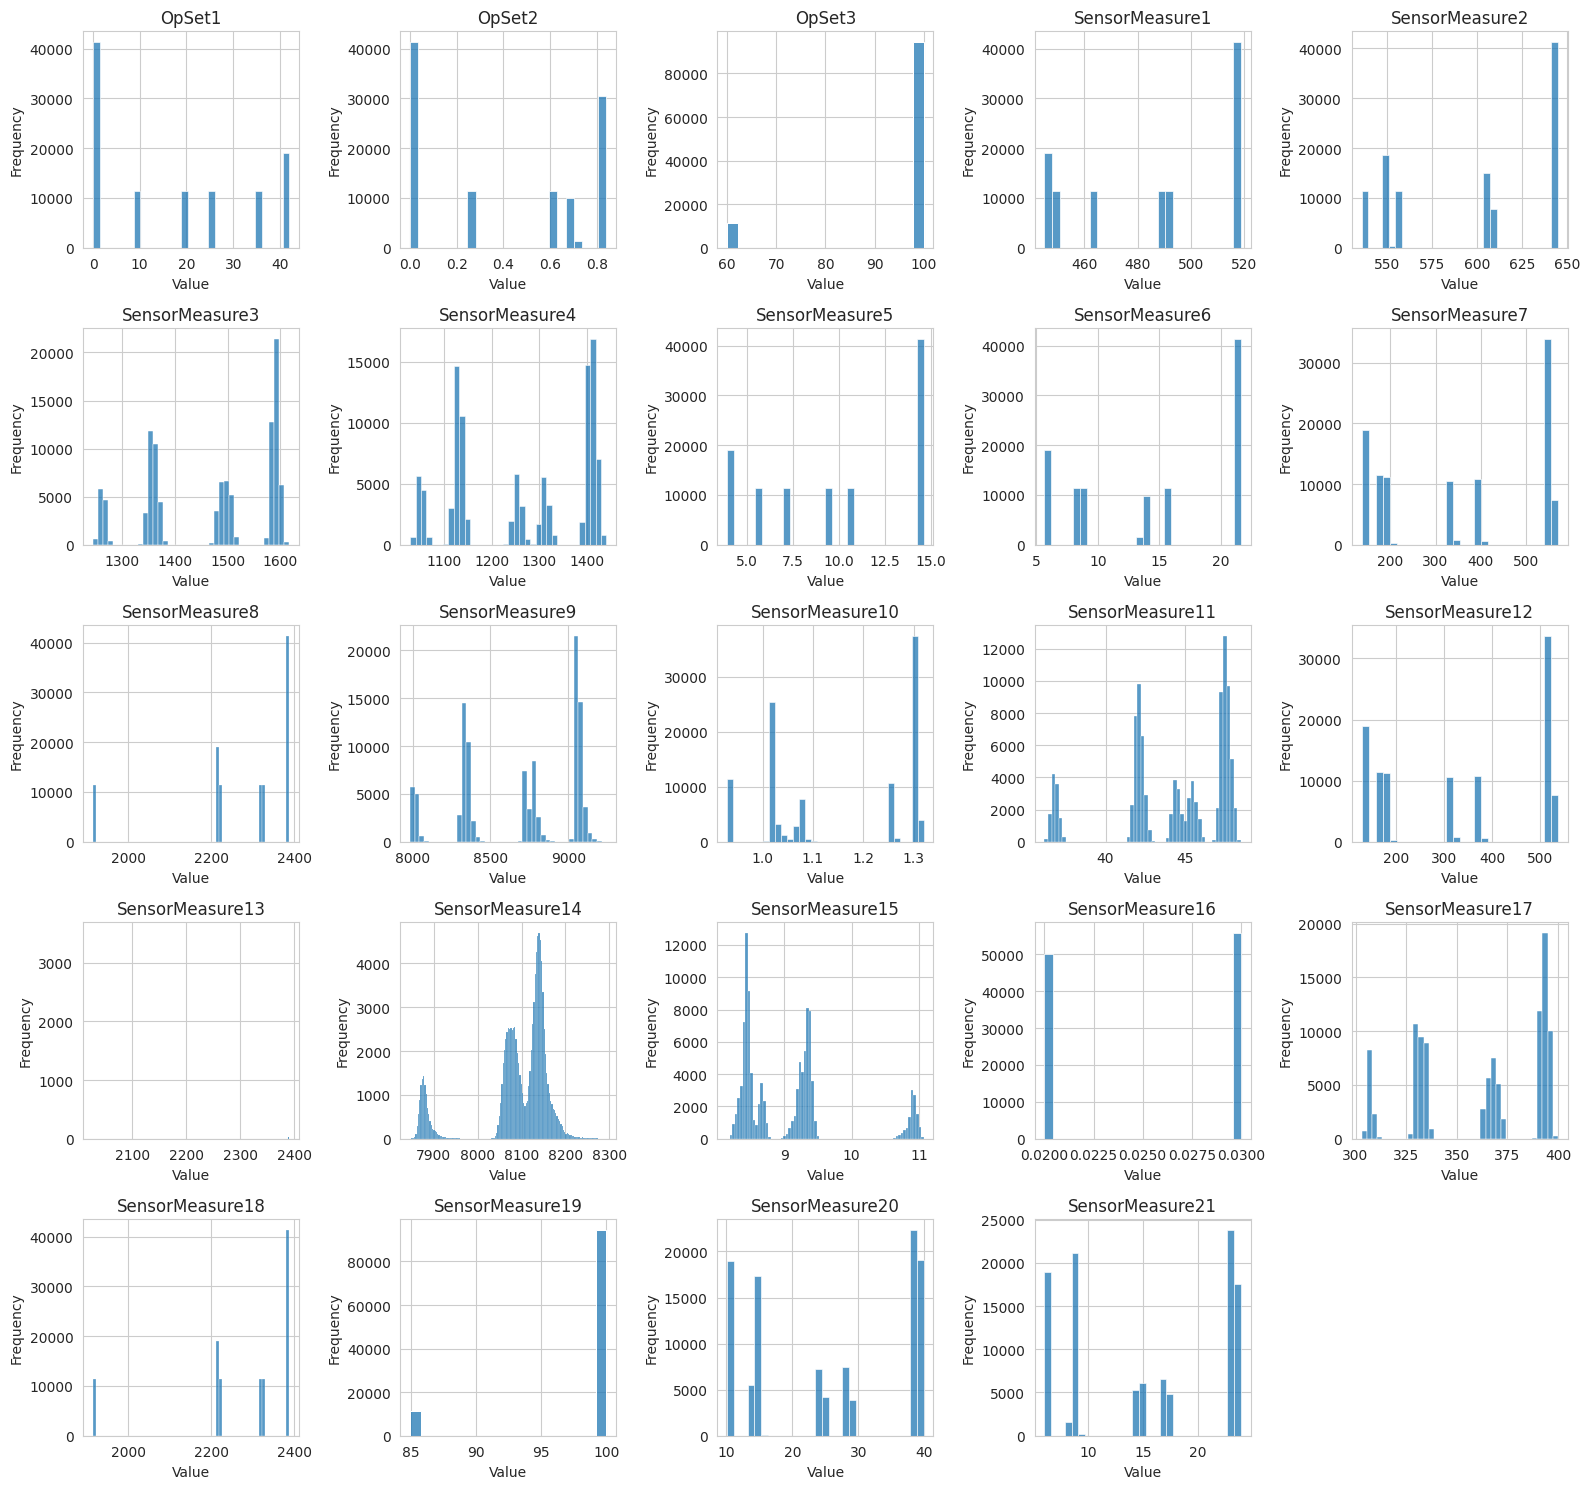

In [ ]:
numeric_columns = processed_train_data.drop('ID', axis=1).select_dtypes(include=np.number).columns
num_plots = len(numeric_columns)
num_plots_per_row = 5
num_rows = int(np.ceil(num_plots / num_plots_per_row))

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(16, 3 * num_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots


for idx, column in enumerate(numeric_columns):
    row_idx = idx // num_plots_per_row
    col_idx = idx % num_plots_per_row
    ax = axes[row_idx, col_idx]

    sns.histplot(processed_train_data[column], ax=ax,)
    ax.set_title(column)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")


# If the number of plots is not a multiple of num_plots_per_row, remove empty subplots
if num_plots % num_plots_per_row != 0:
    empty_subplots = num_plots_per_row - (num_plots % num_plots_per_row)
    for i in range(empty_subplots):
        fig.delaxes(axes.flatten()[-1 - i])

plt.tight_layout()
plt.show()


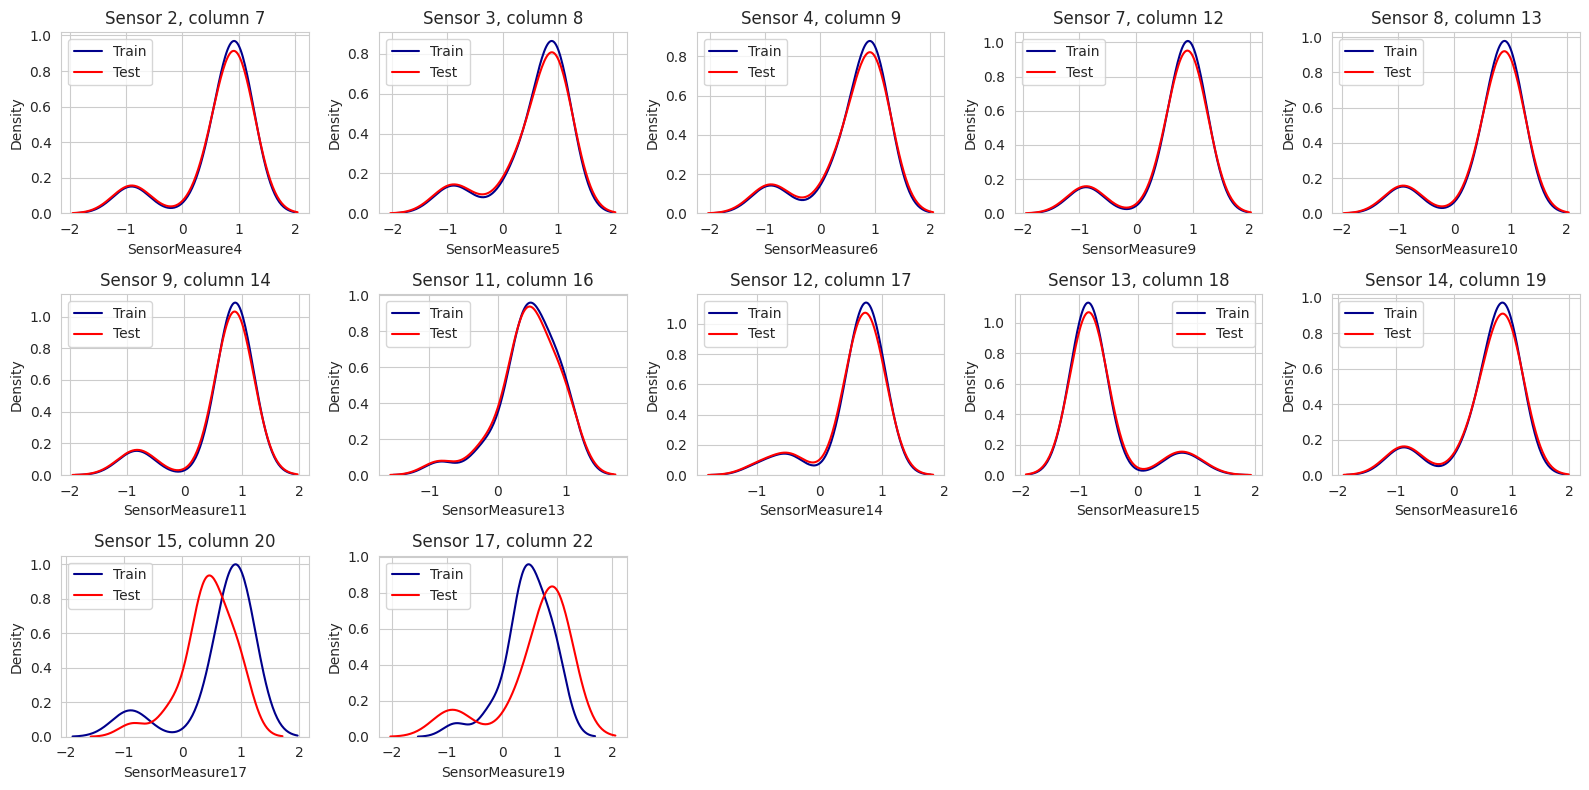

In [ ]:
plt.figure(figsize=(16,8))

# Set the plot background to white
sns.set_style("whitegrid")

selected_columns = [6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21]
num_plots = len(selected_columns)
num_plots_per_row = 5
num_rows = int(np.ceil(num_plots / num_plots_per_row))


for i, col_idx in enumerate(selected_columns):
    temp_train = processed_train_data.drop('ID', axis=1).corr().iloc[:, col_idx]
    temp_test = processed_test_data.corr().iloc[:, col_idx]

    plt.subplot(num_rows, num_plots_per_row, i + 1)
    sns.kdeplot(temp_train, legend=False, color="darkblue", label="Train")
    sns.kdeplot(temp_test, legend=False, color="red", label="Test")

    plt.title("Sensor " + str(col_idx - 4) + ", column " + str(col_idx + 1))
    plt.legend()

# Adding some space between subplots
plt.tight_layout()

plt.show()


### **Data Modelling in Numpy Format**

Combined Train and Test Data (FD001+FD002+FD003+FD004)

In [ ]:
path = '/content/drive/MyDrive/Project/Regression/Dataset'

# train and test data path
train_path = [path + "train_FD001.txt", path + "train_FD002.txt",
              path + "train_FD003.txt", path + "train_FD004.txt"]

test_path = [path + "test_FD001.txt", path + "test_FD002.txt",
              path + "test_FD003.txt", path + "test_FD004.txt"]

rul_path = [path + "RUL_FD001.txt", path + "RUL_FD002.txt",
              path + "RUL_FD003.txt", path + "RUL_FD004.txt"]

# Attributes to be renamed
column_names = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2',
                   'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7',
                   'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12',
                   'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17',
                   'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']


# Declaration of empty lists to store the processed data
stacked_train_X=[]
stacked_train_y=[]
stacked_test_X=[]
stacked_test_y=[]
data_collector = []


# Iterating through all four data files; train and test
for i in range(4):
  train = pd.read_csv(train_path[i], sep=' ', header = None)
  test = pd.read_csv(test_path[i], sep=' ', header = None)
  rul = pd.read_csv(rul_path[i], sep=' ', header = None)

  # reset index to prevent slicing errors
  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)
  rul.reset_index(drop=True, inplace=True)

  # drop unnecessary NAN columns
  train = train.drop([26,27], axis='columns')
  # rename columns from default names to relevant attributes
  train.columns = column_names


  # estimating rul for training data
  '''
  the code calculates the remaining cycles for each engine unit by determining how many
  more cycles can be completed before reaching the point of engine failure. It calculates
  the difference between the maximum cycle number recorded for that engine (representing
  its complete life cycle) and the current cycle numbers recorded for that engine.
  '''
  rul_store = []
  for id in train['ID'].unique():
    complete_cycles = train[train['ID']==id]['Cycle'].max()
    remaining = complete_cycles-train[train['ID']==id]['Cycle'].to_list()
    rul_store = rul_store+list(remaining)

  train['RUL'] = rul_store

  # drop unnecessary NAN columns
  test = test.drop([26,27], axis='columns')
  # rename columns from default names to relevant attributes
  test.columns = column_names


  # drop unnecessary NAN columns
  rul.drop([1], axis='columns', inplace=True)
  # rename columns from default names to relevant attributes
  rul.columns = ['RUL']

  new_test = pd.DataFrame(columns=column_names)
  new_rul = []
  for i in range(len(rul)):
    new_test = new_test.append(test[test['ID']==(i+1)].tail(1))

  temp_train_data = train.copy()
  train.drop(['ID'], axis=1, inplace=True)


  '''
  the DataFrame train will contain only the rows where the Remaining Useful Life (RUL) is
  less than 175. This kind of filtering can be useful for various purposes, such as focusing
  on a specific range of RUL values during analysis or model training.
  '''
  train = train[train['RUL']<175]
  train.reset_index(drop=True, inplace=True)

  # Separate train features and target(RUL)
  train.drop('Cycle', axis=1, inplace=True)
  X_train = train.drop('RUL', axis=1)
  y_train = train['RUL']

  # Separate test features and target(RUL)
  X_test = new_test.drop(['ID', 'Cycle'], axis=1)
  y_test = rul

  # Normalisation
  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  print(X_train.shape, y_train.shape)
  print(X_test.shape, y_test.shape)

  # Store the splitted data of each train and test file to combine all the data for mass training and validation
  stacked_train_X.append(X_train)
  stacked_train_y.append(y_train)
  stacked_test_X.append(X_test)
  stacked_test_y.append(y_test)

  # collecting all the data as (train_data, test_data, X_train, y_train, X_test, y_test)
  data_collector.append((temp_train_data, test, X_train, y_train, X_test, y_test))

(17019, 24) (17019,)
(100, 24) (100, 1)
(44262, 24) (44262,)
(259, 24) (259, 1)
(17287, 24) (17287,)
(100, 24) (100, 1)
(42908, 24) (42908,)
(248, 24) (248, 1)


In [ ]:
# Concat all subsets of data(FD001+FD002_FD003+FD004) to form a single bigger meta data - train data
processed_train_data = np.concatenate(stacked_train_X)
# Concat all subsets of data(FD001+FD002_FD003+FD004) to form a single bigger meta data - train target
processed_train_targets = np.concatenate(stacked_train_y)

# Concat all subsets of data(FD001+FD002_FD003+FD004) to form a single bigger meta data - test data
processed_test_data = np.concatenate(stacked_test_X)
# Concat all subsets of data(FD001+FD002_FD003+FD004) to form a single bigger meta data - train target
processed_test_targets = np.concatenate(stacked_test_y)

print("TRAINING-->")
print(f"Shape of processed_train_data: {processed_train_data.shape}")
print(f"Shape of processed_train_targets: {processed_train_targets.shape}")

print()
print("TESTING-->")
print(f"Shape of processed_test_data: {processed_test_data.shape}")
print(f"Shape of processed_test_targets: {processed_test_targets.shape}")

TRAINING-->
Shape of processed_train_data: (121476, 24)
Shape of processed_train_targets: (121476,)

TESTING-->
Shape of processed_test_data: (707, 24)
Shape of processed_test_targets: (707, 1)


In [ ]:
X_train = processed_train_data
X_test = processed_test_data

y_train = processed_train_targets
y_test = processed_test_targets

## Decision Tree Regression

In [ ]:
dt_clf = DecisionTreeRegressor()
dt_clf.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
dt_y_pred = dt_clf.predict(X_test)
dt_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, dt_y_pred))
dt_test_mae = metrics.mean_absolute_error(y_test, dt_y_pred)
dt_test_r2 = metrics.r2_score([item for sublist in y_test for item in sublist], dt_y_pred)
print("Root Mean Squared Error (RMSE): ", dt_test_rmse)
print("Mean Absolute Error (MAE): ", dt_test_mae)
print("R2 Score: ", dt_test_r2)

Root Mean Squared Error (RMSE):  39.05434504691952
Mean Absolute Error (MAE):  28.905233380480905
R2 Score:  0.41525487369390557


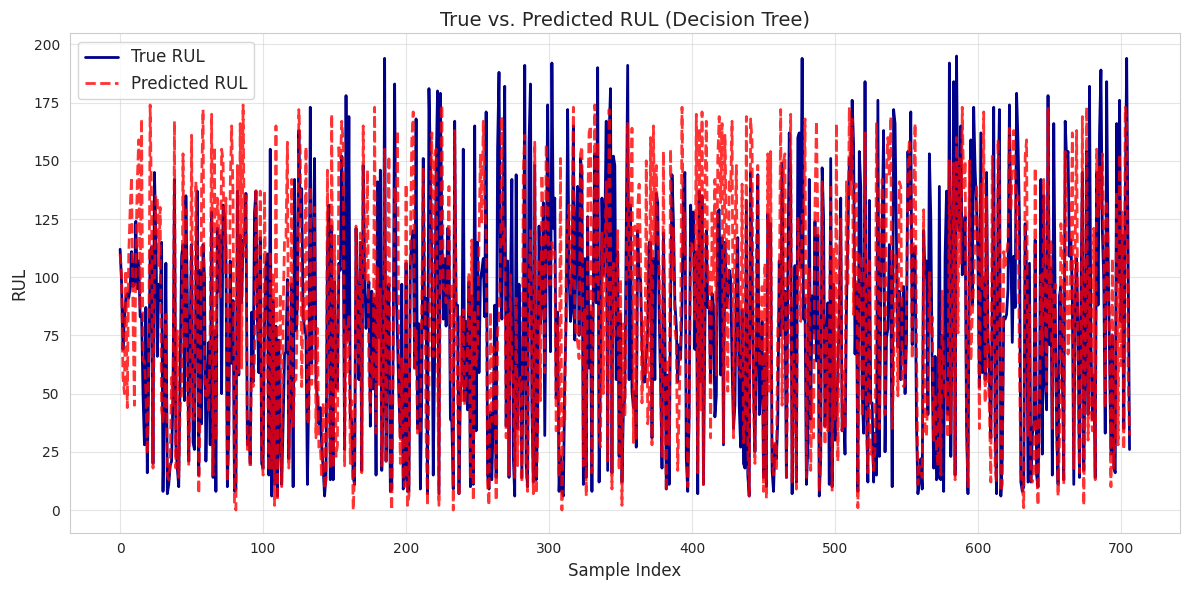

In [ ]:
plot_predActual(y_test, dt_y_pred, data_mode='Decision Tree')
plt.show()

In [ ]:
# Create a scatter plot
fig = px.scatter(x=[item for sublist in y_test for item in sublist], y=list(dt_y_pred),
                 labels={'x': 'y_test', 'y': 'dt_y_pred'})

# Add a regression line
fig.add_trace(go.Scatter(x=[item for sublist in y_test for item in sublist],
                         y=[item for sublist in y_test for item in sublist],
                         mode='lines', name='Regression Line'))

# Update the layout for better visualization (optional)
fig.update_layout(
    title="Linear Results: y_test vs. dt_y_pred",
    xaxis_title="y_test",
    yaxis_title="dt_y_pred",
    showlegend=True,
)

# Show the plot
fig.show()


## Random Forest

In [ ]:
rf_clf = RandomForestRegressor()
rf_clf.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
rf_y_pred = rf_clf.predict(X_train)
rf_train_rmse = np.sqrt(metrics.mean_squared_error(y_train, rf_y_pred))
print(rf_train_rmse)

10.005923101164845


In [ ]:
# Create a scatter plot
fig = px.scatter(x=y_train, y=rf_y_pred, labels={'x': 'y_test', 'y': 'rf_y_pred'})

# Add a regression line
fig.add_trace(go.Scatter(x=y_train, y=y_train, mode='lines', name='Regression Line'))

# Update the layout for better visualization (optional)
fig.update_layout(
    title="Linear Results: y_test vs. rf_y_pred",
    xaxis_title="y_test",
    yaxis_title="rf_y_pred",
    showlegend=True,
)

# Show the plot
fig.show()


In [ ]:
rf_y_pred = rf_clf.predict(X_test)
rf_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, rf_y_pred))
rf_test_mae = metrics.mean_absolute_error(y_test, rf_y_pred)
print("Root Mean Squared Error (RMSE): ", rf_test_rmse)
print("Mean Absolute Error (MAE): ", rf_test_mae)

Root Mean Squared Error (RMSE):  27.035652049726664
Mean Absolute Error (MAE):  19.86990099009901


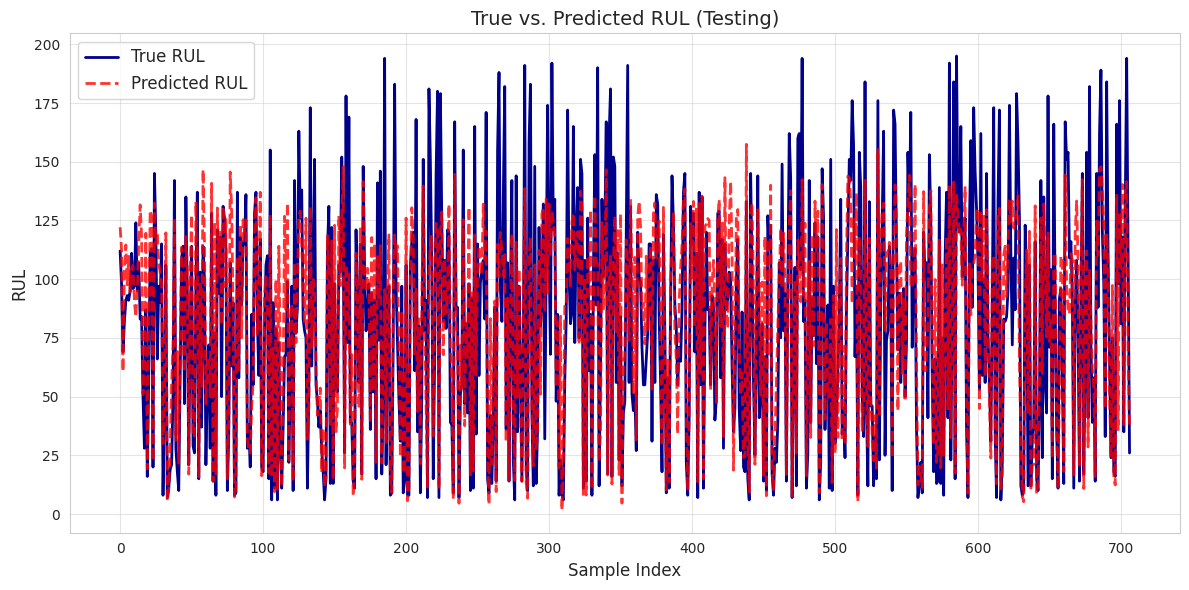

In [ ]:
plot_predActual(y_test, rf_y_pred, data_mode='Testing')
plt.show()

In [ ]:
# Create a scatter plot
fig = px.scatter(x=[item for sublist in y_test for item in sublist], y=list(rf_y_pred),
                 labels={'x': 'y_test', 'y': 'rf_y_pred'})

# Add a regression line
fig.add_trace(go.Scatter(x=[item for sublist in y_test for item in sublist],
                         y=[item for sublist in y_test for item in sublist],
                         mode='lines', name='Regression Line'))

# Update the layout for better visualization (optional)
fig.update_layout(
    title="Linear Results: y_test vs. rf_y_pred",
    xaxis_title="y_test",
    yaxis_title="rf_y_pred",
    showlegend=True,
)

# Show the plot
fig.show()


In [ ]:
rf_test_r2 = metrics.r2_score([item for sublist in y_test for item in sublist], rf_y_pred)
print("R2 Score: ", rf_test_r2)

R2 Score:  0.719778412113729


In [ ]:
# Results DataFrame
scores = {'Model': ['Decision Tree', 'Random Forest', 'LSTM'],
          'RMSE': [dt_test_rmse, rf_test_rmse, 0.29],
          'MAE': [dt_test_mae, rf_test_mae,  0.26],
          'r2_score': [dt_test_r2, rf_test_r2, 0.1]}

results = pd.DataFrame(scores, columns = ['Model', 'RMSE', 'MAE', 'r2_score'])
results

,Model,RMSE,MAE,r2_score
0,Decision Tree,39.054345,28.905233,0.415255
1,Random Forest,27.035652,19.869901,0.719778
2,LSTM,0.290000,0.260000,0.100000


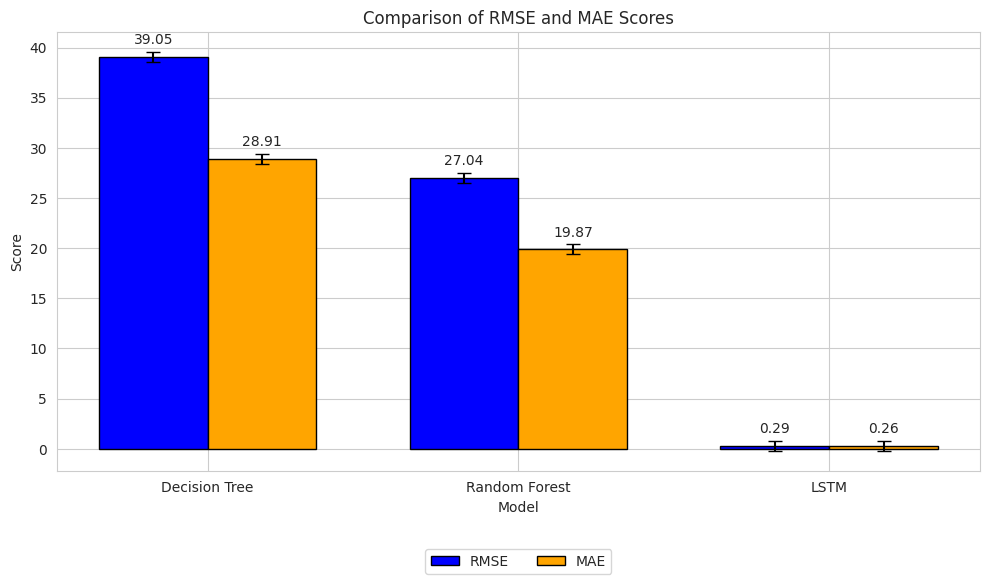

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

bar_width = 0.35
index = range(len(results['Model']))

# Plot RMSE and MAE bars
plt.bar(index, results['RMSE'], bar_width, label='RMSE', color='blue', edgecolor='black', linewidth=1)
plt.bar([i + bar_width for i in index], results['MAE'], bar_width, label='MAE', color='orange', edgecolor='black', linewidth=1)

# Adding error bars
plt.errorbar(index, results['RMSE'], linestyle='None', yerr=0.5, color='black', capsize=5)
plt.errorbar([i + bar_width for i in index], results['MAE'], linestyle='None', yerr=0.5, color='black', capsize=5)

# Adding score values above bars
for i in index:
    plt.text(i, results['RMSE'][i] + 1, f'{results["RMSE"][i]:.2f}', ha='center', va='bottom', fontsize=10)
    plt.text(i + bar_width, results['MAE'][i] + 1, f'{results["MAE"][i]:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Comparison of RMSE and MAE Scores')
plt.xticks([i + bar_width/2 for i in index], results['Model'])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(results['Model']))
plt.tight_layout()

plt.show()


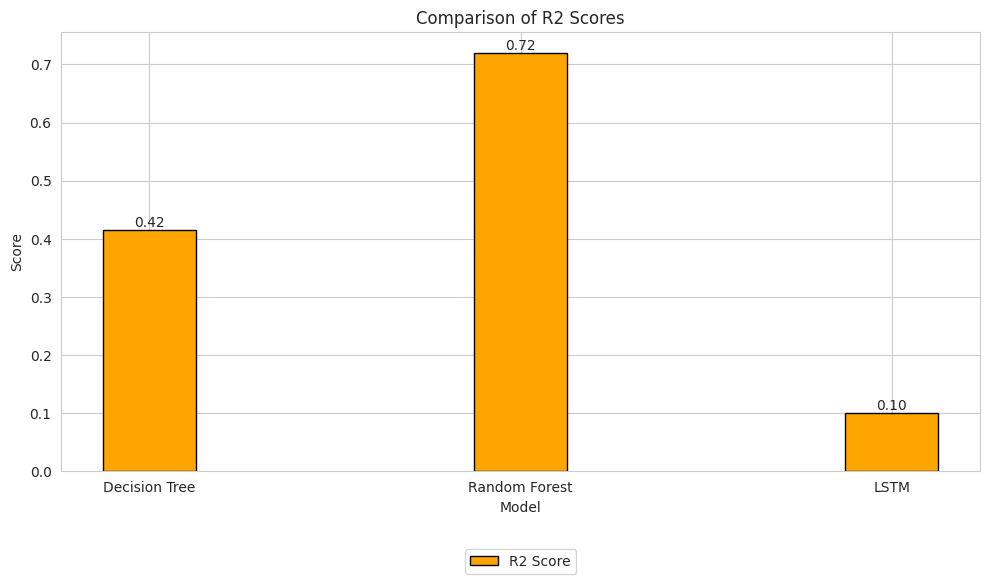

In [ ]:
plt.figure(figsize=(10, 6))

bar_width = 0.25  # Decreased bar width
index = range(len(results['Model']))

# Plot R2 Score bars
plt.bar(index, results['r2_score'], bar_width, label='R2 Score', color='orange', edgecolor='black', linewidth=1)

# Adding score values above bars
for i in index:
    plt.text(i, results['r2_score'][i], f'{results["r2_score"][i]:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Comparison of R2 Scores')
plt.xticks([i for i in index], results['Model'])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(results['Model']))
plt.tight_layout()

plt.show()